In [2]:
# Change the working directory to the root of the project by moving up in the
# directory tree until the file '.gitignore' is found.
import os

while not os.path.exists('.gitignore'):
    os.chdir('..')

# Set to True to run the notebook quickly for testing purposes This is done
# automatically in 'tests/test_run_notebooks.py'
quick_mode = False

In [3]:
# injected parameters
quick_mode = False

In [5]:
import matplotlib.pyplot as plt

from usbmd import setup, Config
from usbmd.data import load_usbmd_file
from usbmd.ops_v2 import Pipeline
from usbmd.display import to_8bit
from usbmd.ops_v2 import PatchedGrid, EnvelopeDetect, Normalize, LogCompress, TOFCorrection, PfieldWeighting, DelayAndSum
from usbmd.utils.visualize import set_mpl_style

usbmd: WARNING WARNING: This module is work in progress and may not work as expected!


In [ ]:
if not quick_mode:
    # choose your config file
    # all necessary settings should be in the config file
    config_path = "./configs/config_usbmd_carotid.yaml"

    # setup function handles local data paths, default config settings and GPU usage
    # make sure to create your own users.yaml using usbmd/datapaths.py
    users_paths = "./users.yaml"
    config = setup(config_path, users_paths, create_user=True)

    # we now manually point to our data
    data_root = config.data.user.data_root
    user = config.data.user.username

    print(f"\n🔔 Hi {user}! You are using data from {data_root}\n")

    # dataset_folder: USBMD_datasets/2023_USBMD_carotid/HDF5
    dataset_folder = config.data.dataset_folder

    # file_path: 2_cross_bifur_right_0000.hdf5
    file = config.data.file_path
    data_path = data_root / dataset_folder / file

    assert data_path.exists(), f"🚫 Data path does not exist: {data_path}, please check your paths"

    set_mpl_style()

usbmd: Using config file: ./configs/config_usbmd_carotid.yaml


usbmd: Git branch and commit: feature/interface-update=88af98aaae0ad18009517b5253c72292576f7224
usbmd: Data paths set successfully.
usbmd: Here's a summary of your data paths:
	data_root: /mnt/z/Ultrasound-BMd/data
	repo_root: /ultrasound-toolbox/usbmd/datapaths.py
	output: /mnt/z/Ultrasound-BMd/pretrained
	system: linux
	username: devcontainer15
	hostname: 453462d5764f

-------------------GPU settings-------------------
     memory
GPU        
0      2578
1     11011
2     11011
3        24
4     11011
5     11011
6     11011
7     11011
Selected GPU 1 with Free Memory: 11011.00 MiB
Hiding GPUs [0, 2, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------

🔔 Hi devcontainer15! You are using data from /mnt/z/Ultrasound-BMd/data



In [ ]:
if not quick_mode:
    # only 1 frame is loaded for this example
    selected_frames = [0]

    # loading a file manually using `load_usbmd_file`
    data, scan, probe = load_usbmd_file(
        data_path, frames=selected_frames, config=config, data_type="raw_data"
    )

    # index the first frame
    data_frame = data[0]

usbmd: WARNING The probe geometry in the data file does not match the probe geometry of the probe. The probe geometry has been updated to match the data file.


usbmd: WARNING width/Nx = 0.0001235 < wvln/2 = 9.856e-05. Consider increasing scan.Nx to 377 or more.
usbmd: WARNING depth/Nz = 0.0001072 < wvln/2 = 0.0000986. Consider increasing scan.Nz to 544 or more.


In [ ]:
# showing the current pipeline from config
# you can see we have a nested pipeline (PatchedGrid is also a pipeline)
if not quick_mode:
    print(config.pipeline)

<Config {'operations': [{'name': 'patched_grid', 'params': {'operations': [{'name': 'tof_correction'}, {'name': 'pfield_weighting'}, {'name': 'delay_and_sum'}], 'num_patches': 100}}, {'name': 'envelope_detect'}, {'name': 'normalize'}, {'name': 'log_compress'}]}>


2025-03-12 09:48:13.886310: I external/xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


usbmd: Computing pressure field for all transmits
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/transmits


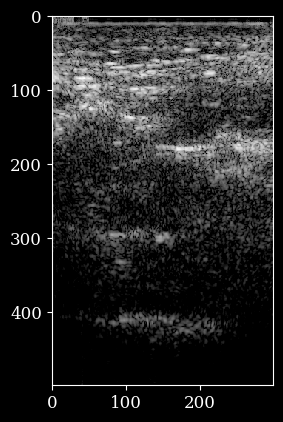

In [ ]:
pipeline_config = Config({
    "operations": [
        {
            "name": "patched_grid",
            "params": {
                "operations": [
                    {"name": "tof_correction"},
                    {"name": "pfield_weighting"},
                    {"name": "delay_and_sum"}
                ],
                "num_patches": 100
            }
        },
        {"name": "envelope_detect"},
        {"name": "normalize"},
        # static parameters always go in init of the Operations, which can also be
        # defined here in the config (if not defaults are used)
        {"name": "log_compress", "params": {"key": "envelope_data", "output_key": "image"}}
    ]
}
)

pipeline = Pipeline.from_config(pipeline_config, with_batch_dim=False, jit_options="pipeline")

input_key = pipeline.key
output_key = pipeline.output_key

if not quick_mode:
    inputs = {input_key: data_frame}

    # dynamic parameters can be freely passed here as keyword arguments
    outputs = pipeline(scan, probe, config, **inputs)

    image = outputs[output_key]

    image_display = to_8bit(image, config.data.dynamic_range)

    plt.figure()
    plt.imshow(image_display, cmap="gray")

usbmd: Computing pressure field for all transmits
  1/149 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/transmits

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/transmits


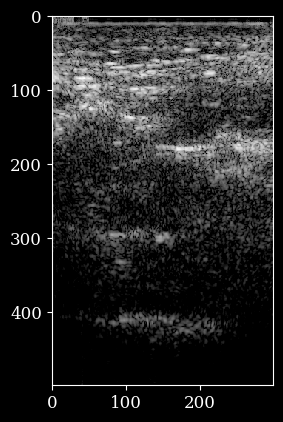

In [ ]:
# now let's use the pipeline with the same operations but with the classes directly
# instead of using the config file / dictionary

pipeline = Pipeline(
    operations = [
        PatchedGrid(
            operations = [
                TOFCorrection(),
                PfieldWeighting(),
                DelayAndSum()
            ],
            num_patches = 100
        ),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    with_batch_dim = False,
    jit_options = "pipeline",
)

if not quick_mode:
    outputs = pipeline(scan, probe, config, dynamic_range=(-50, 0), **inputs)

    image = outputs[output_key]

    image_display = to_8bit(image, config.data.dynamic_range)

    plt.figure()
    plt.imshow(image_display, cmap="gray")

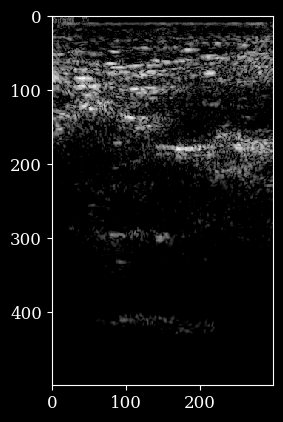

In [ ]:
# changing some parameters on the fly with compile pipeline
# should be also really fast as pipeline was already compiled
if not quick_mode:
    dynamic_range = (-30, 0)

    outputs = pipeline(scan, probe, config, dynamic_range=dynamic_range, **inputs)

    image = outputs[output_key]

    image_display = to_8bit(image, dynamic_range)

    plt.figure()
    plt.imshow(image_display, cmap="gray")

usbmd: WARNING width/Nx = 0.0001235 < wvln/2 = 9.856e-05. Consider increasing scan.Nx to 377 or more.
usbmd: WARNING depth/Nz = 0.0001072 < wvln/2 = 0.0000986. Consider increasing scan.Nz to 544 or more.
usbmd: Computing pressure field for all transmits
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/transmits


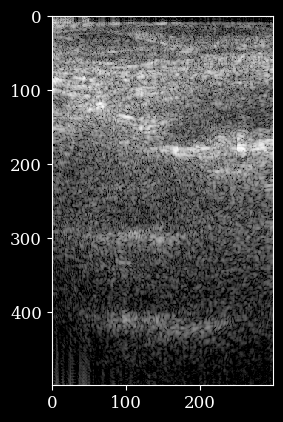

In [ ]:
# Let's see how to change the number of transmits for reconstruction

# set selected_transmits such that internal parameters are updated
if not quick_mode:
    scan.selected_transmits = 11

    data_11_transmits = data[0][scan.selected_transmits]

    inputs = {input_key: data_11_transmits}

    outputs = pipeline(scan, probe, config, **inputs)

    image = outputs[output_key]

    image_display = to_8bit(image, dynamic_range)

    plt.figure()
    plt.imshow(image_display, cmap="gray")